<a href="https://colab.research.google.com/github/ShawnLiu119/CreditDefault_TS-DL-_XGBoost/blob/main/CreditDefault_TimeSeries%2BXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Default Prediction - TimeSeries(RNN) + XGBoost Approach**

Reference:https://developer.nvidia.com/blog/predicting-credit-defaults-using-time-series-models-with-recursive-neural-networks-and-xgboost/

Rationale: <br>
**credit data is mostly cylce-based with time series nature**. Deep neural networks, on the other hand, excel at learning long-term temporal dependencies and sequential patterns in data. They also can automatically extract features from raw data. Recently, **deep neural networks have been widely used to generate high-quality new data, by exploiting their ability to learn the distribution from the existing data.**

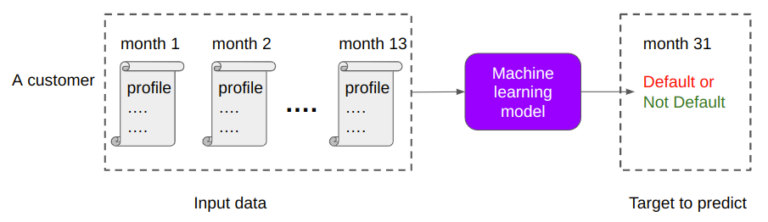


###Term:

**NVDIA RAPIDS** is a suite of GPU-accelerated data science and AI libraries with APIs that match popular open-source data tools

**cuDF (pronounced “KOO-dee-eff”)** is a Python GPU DataFrame library (built on the Apache Arrow columnar memory format) for loading, joining, aggregating, filtering, and otherwise manipulating data. cuDF also provides a pandas-like API that will be familiar to data engineers & data scientists, so they can use it to easily accelerate their workflows without going into the details of CUDA programming. cudf.pandas is built on cuDF and accelerates pandas code on the GPU

https://developer.nvidia.com/blog/predicting-credit-defaults-using-time-series-models-with-recursive-neural-networks-and-xgboost/
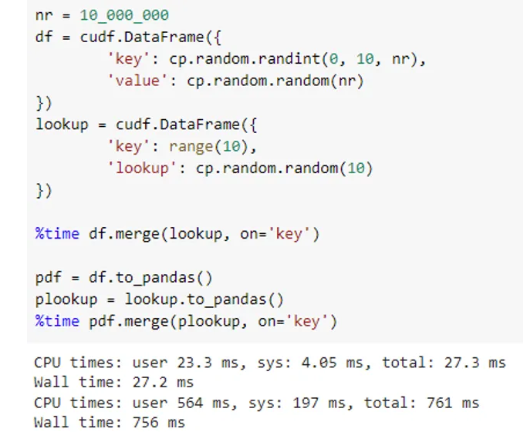

Reference Notebook:
https://github.com/daxiongshu/triton_amex/tree/check_23_04


## Step 1 - Dataset

In [1]:
import os

**pip vs conda**
Use pip if you are working with pure Python projects and need access to the vast array of libraries available on PyPI. Use conda if you are working with projects that use multiple languages, need different versions of Python, or require complex binary dependencies.

In [11]:
#cuDF install guide https://docs.rapids.ai/install
# !pip install \
#     --extra-index-url=https://pypi.nvidia.com \
#     cudf-cu12==24.6.* dask-cudf-cu12==24.6.* cuml-cu12==24.6.* \
#     cugraph-cu12==24.6.* cuspatial-cu12==24.6.* cuproj-cu12==24.6.* \
#     cuxfilter-cu12==24.6.* cucim-cu12==24.6.* pylibraft-cu12==24.6.* \
#     raft-dask-cu12==24.6.* cuvs-cu12==24.6.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.7/477.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 667.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 109.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.8/833.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 693.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=180f27ec00617cf3cf7eb59fc34fb8b168b3997748a70fab603764f2bae0f506
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [6]:
!pip install python-utils==3.8.2

In [9]:
import cudf
import pandas as pd
import cupy
#Google Colaboratory now provides Chainer, CuPy and iDeep by default. Manual installation is no longer necessary.
from tqdm import tqdm
import numpy as np
import gc
import xgboost as xgb
# from python-utils import amex_metric_np
from pathlib import Path

cudf.__version__, xgb.__version__

('24.04.01', '2.0.3')

Navigate to https://www.kaggle.com. Then go to the Account tab of your user profile and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [11]:
!kaggle datasets list -s [Bank] #search all datasets with Keyword 'Bank' in Kaggle

ref                                                 title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
henriqueyamahata/bank-marketing                     Bank Marketing                                 393KB  2018-06-06 15:19:35          41244        389  0.64705884       
janiobachmann/bank-marketing-dataset                Bank Marketing Dataset                         142KB  2017-11-12 19:20:01          57294        481  0.8235294        
radheshyamkollipara/bank-customer-churn             Bank Customer Churn                            307KB  2023-04-28 16:32:01          14931        150  1.0              
santoshd3/bank-customers                            Bank Customers Churn                           262KB  2018-07-09 09:06:39          12766     

In [30]:
!kaggle datasets list -s [amex-default-prediction]

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/parquet-files-amexdefault-prediction                       Feather & Parquet Files : AMEX-Default Prediction    22GB  2022-05-26 05:46:53           2076        164  1.0              
thedevastator/amex-fe                                               AMEX lag features                                     6GB  2022-07-06 14:52:26            367         23  1.0              
seefun/amex-default-prediction-feather                              AMEX-Default Prediction: Feather Dataset              4GB  2022-05-27 04:21:41            600         16  0.4375           
arpan129/default-time-prediction-multicl

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
#download dataset
PATH = '/content/drive/MyDrive/kaggle_data/amex'

In [14]:
from pathlib import Path
Path(PATH).mkdir(parents=True,exist_ok=True) #you can specify an existing directory without encountering an error

In [9]:
cmd = f'kaggle datasets download -d raddar/amex-data-integer-dtypes-parquet-format -p {PATH}' #download using Kaggle API

In [12]:
os.system(cmd)

0

In [15]:
os.listdir(PATH)

['amex-data-integer-dtypes-parquet-format.zip']

In [16]:
#run cmd instead of python API
cmd = f'cd {PATH} && unzip amex-data-integer-dtypes-parquet-format.zip'
os.system(cmd)

0

In [17]:
os.listdir(PATH)

['amex-data-integer-dtypes-parquet-format.zip',
 'test.parquet',
 'train.parquet']

### EDA - only X variables

In [18]:
%%time
#%%time prints the wall time for the entire cell whereas %time gives you the time for first line only

train = cudf.read_parquet(f'{PATH}/train.parquet') #use cudf instead of pd
print(train.shape)
train.head()

(5531451, 190)
CPU times: user 887 ms, sys: 1.19 s, total: 2.08 s
Wall time: 2.82 s


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,<NA>,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,<NA>,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,<NA>,0,0.008126,0


In [19]:
%%time
count_df = train.groupby('customer_ID').size().to_frame('num_vintages')
count_df.head()

CPU times: user 77.4 ms, sys: 28.9 ms, total: 106 ms
Wall time: 197 ms


,num_vintages
customer_ID,
48cf719c974688d894a1329ba7adb2b4900c13edc8f8c6d34bfdedba0c46bb03,13
0ba011576f52ae62ce04c45929e5aa5830d2be0f142b96b0b7ab6c809c6e5b8c,13
e95509814416057e5c095e1e36cf8424412b251ba876149e476abb15b0388f5c,13
33aa4c3e70f560024f04cf2599e21aadceb37c196d3a6a0914eb5c44f10835c8,12
91fd7390bce6486763206daae24eacb745dffe8b44fe8cbad1ef65f001153408,12


not every customer has 13 month data

In [20]:
count_df.num_vintages.max()

13

In [21]:
count_df.num_vintages.min()

1

In [22]:
%%time
train['S_2'] = cudf.to_datetime(train['S_2'])
train.head()

CPU times: user 70.9 ms, sys: 23.4 ms, total: 94.2 ms
Wall time: 186 ms


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,<NA>,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,<NA>,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,<NA>,0,0.008126,0


In [25]:
train.S_2.min(), train.S_2.max()

(numpy.datetime64('2017-03-01T00:00:00.000000000'),
 numpy.datetime64('2018-03-31T00:00:00.000000000'))

### Download training Y variable

In [32]:
# cmd = f'kaggle datasets download -c amex-default-prediction -f train_labels.csv -p {PATH}/'
# os.system(cmd)

512

In [33]:
cmd = f'cd {PATH} && unzip train_labels.csv.zip'
os.system(cmd)

2304

In [34]:
%%time
trainl = cudf.read_csv(f'{PATH}/train_labels.csv')
print(trainl.shape)
trainl.head()

(458913, 2)
CPU times: user 33.8 ms, sys: 28.5 ms, total: 62.3 ms
Wall time: 1.3 s


,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [35]:
trainl['target'].value_counts()

target
0    340085
1    118828
Name: count, dtype: int64

In [36]:
%%time
train = train.merge(trainl, on='customer_ID', how='left')
print(train.shape)
train.head()

(5531451, 191)
CPU times: user 256 ms, sys: 13.8 ms, total: 270 ms
Wall time: 292 ms


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,003b8acbe4a0440cc0793413cb667ff2aea374ff675c67...,2018-02-18,0.884634,5,0.026396,1.009772,0.008060,0.129312292,0.0,0.009238,...,-1,-1,0,0,0.0,<NA>,0,0.005912,0,0
1,003b8acbe4a0440cc0793413cb667ff2aea374ff675c67...,2018-03-19,0.889992,3,0.052416,1.007976,0.004681,0.127632976,0.0,0.011736,...,-1,-1,0,0,0.0,<NA>,0,0.004117,0,0
2,003bbd1b2d52941af2288c0bc80a391678dfcccd6711ae...,2017-03-30,0.983521,0,0.002005,0.814890,0.006996,<NA>,0.0,0.003853,...,-1,-1,0,0,0.0,<NA>,0,0.007842,0,0
3,003bbd1b2d52941af2288c0bc80a391678dfcccd6711ae...,2017-04-29,0.969846,0,0.010137,0.817163,0.006400,<NA>,0.0,0.005680,...,-1,-1,0,0,0.0,<NA>,0,0.008720,0,0
4,003bbd1b2d52941af2288c0bc80a391678dfcccd6711ae...,2017-05-30,0.968277,0,0.006199,0.813610,0.004397,<NA>,0.0,0.008355,...,-1,-1,0,0,0.0,<NA>,0,0.000028,0,0


In [37]:
train['cid'], _ = train.customer_ID.factorize()
#Pandas Series.factorize() function encode the object as an enumerated type or categorical variable.
#This method is useful for obtaining a numeric representation of an array when all that matters is identifying distinct values.

In [38]:
train['cid'].head()

0    0
1    0
2    1
3    1
4    1
Name: cid, dtype: int32

In [39]:
mask = train['cid']%4 == 0 #sample by take 4的倍数作为val dataset
tr,va = train.loc[~mask],train.loc[mask]
print("Verify target distribution is consistent across tr and va")
print(tr['target'].mean(), va['target'].mean()) #bad rate

Verify target distribution is consistent across tr and va
0.2497808785300493 0.24704660005625179
